In [38]:
!pip install pyworld


In [2]:
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt
import pyworld
from librosa.display import specshow

#1. a. ii. The sampling frequency of the audio

In [39]:
# Load audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    return audio, sr

file_path = "/content/recording.ogg"
audio, sampling_rate = load_audio(file_path)
print(f'The sampling rate : {sampling_rate}')

The sampling rate : 16000


#1. b.

In [40]:
# Resample to a new sampling rate using scipy.signal.resample
def resample_audio(audio, original_sr, target_sr):
    num_samples = round(len(audio) * float(target_sr) / original_sr)
    resampled_audio = scipy.signal.resample(audio, num_samples)
    return resampled_audio.astype(np.float32)

In [41]:
# Resample to 32KHz
audio_32kHz = resample_audio(audio, sampling_rate, 32000)

# 1. c.

In [42]:
even_samples = audio_32kHz[::2]
audio_16kHz = resample_audio(audio_32kHz, 32000, 16000)

# 1. d.

In [43]:
# Plot function
def spectrogram(audio, sampling_rate):
    n_fft = int(sampling_rate * 0.02)  # 20 ms window size
    hop_length = int(sampling_rate * 0.01)  # 10 ms hop size
    stft = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
    return librosa.amplitude_to_db(stft, ref=np.max)

def mel_spectrogram(audio, sampling_rate):
    n_fft = int(sampling_rate * 0.02)  # 20 ms window size
    hop_length = int(sampling_rate * 0.01)  # 10 ms hop size
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    return librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

def energy_rms(audio, sampling_rate):
    hop_length = int(sampling_rate * 0.01)  # 10 ms hop size
    return librosa.feature.rms(y=audio, frame_length=int(sampling_rate * 0.02), hop_length=hop_length)[0]

def pitch_contour(audio, sampling_rate):
    f0, time_f0 = pyworld.dio(audio, sampling_rate)
    return time_f0, pyworld.stonemask(audio, f0, time_f0, sampling_rate)

def plot_audio_features(audio, sampling_rate):
    # Convert audio to double for pyworld
    audio = audio.astype(np.float64)

    time = np.arange(len(audio)) / sampling_rate

    spectogram_in_decibal = spectrogram(audio, sampling_rate)

    mel_spectrogram_db = mel_spectrogram(audio, sampling_rate)

    energy = energy_rms(audio, sampling_rate)

    time_f0, pitch = pitch_contour(audio, sampling_rate)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Audio waveform
    plt.subplot(2, 2, 1)
    plt.plot(time, audio)
    plt.title('Audio Waveform')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(2, 2, 2)
    specshow(spectogram_in_decibal, x_axis='time', y_axis='log', sr=sampling_rate, hop_length=int(sampling_rate * 0.01))
    plt.title('Spectrogram')
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(format='%+2.0f dB')

    # Pitch contour on spectrogram
    plt.plot(time_f0, pitch, label='Pitch Contour', color='r', linestyle='dashed')
    plt.legend()

    # Mel-Spectrogram
    plt.subplot(2, 2, 3)
    specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sampling_rate, hop_length=int(sampling_rate * 0.01))
    plt.title('Mel-Spectrogram')
    plt.xlabel('Time [sec]')
    plt.ylabel('Mel Frequency [Hz]')
    plt.colorbar(format='%+2.0f dB')

    # Energy (RMS)
    plt.subplot(2, 2, 4)
    plt.plot(time[:len(energy)], energy)
    plt.title('Energy (RMS)')
    plt.xlabel('Time [sec]')
    plt.ylabel('Energy')

    plt.tight_layout()
    plt.show()


## d. 2. i.
We observe the F-max at a frequency of 8,000 Hz, which corresponds to the Nyquist frequency, as the sampling rate is 16,000 Hz.
## d. 2. i. 2. a.
Missing timeframes in the pitch contour occur because unvoiced sounds (e.g., fricatives like "s" or "f") or silence periods lack periodicity, making pitch estimation impossible

## e.

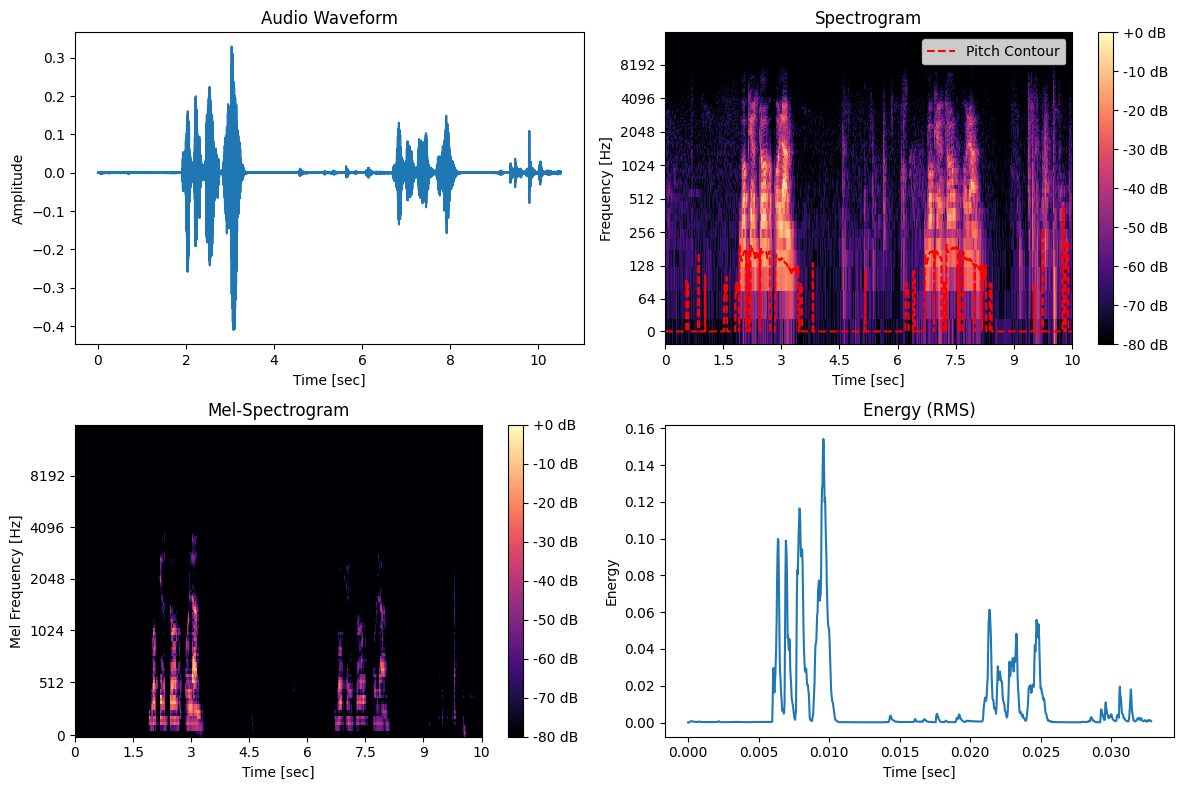

In [44]:
plot_audio_features(audio_32kHz, 32000)

# TODO: COMPLETE THE ANSWER

# 2.
## 2. a.

In [45]:
noise_file_path = "stationary_noise.wav"
noised_audio, sampling_rate = load_audio(file_path)
resampled_noised_audio = resample_audio(noised_audio, sampling_rate, 16000)

## 2. b.

In [46]:
def add_noise_to_audio(audio, noise):
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    elif len(audio) > len(noise):
        audio = audio[:len(noise)]
    noisy_audio = audio + noise
    return audio, noise, noisy_audio

In [47]:
audio, noise, noisy_audio = add_noise_to_audio(audio_16kHz, noised_audio)

## 2. c.

In [48]:
def plot_signals(audio, noise, noisy_audio, sr):
    time = np.arange(len(audio)) / sr

    plt.figure(figsize=(12, 8))

    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time, audio)
    plt.title("Original Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noise
    plt.subplot(3, 1, 2)
    plt.plot(time, noise)
    plt.title("Noise")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noisy audio
    plt.subplot(3, 1, 3)
    plt.plot(time, noisy_audio)
    plt.title("Noisy Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

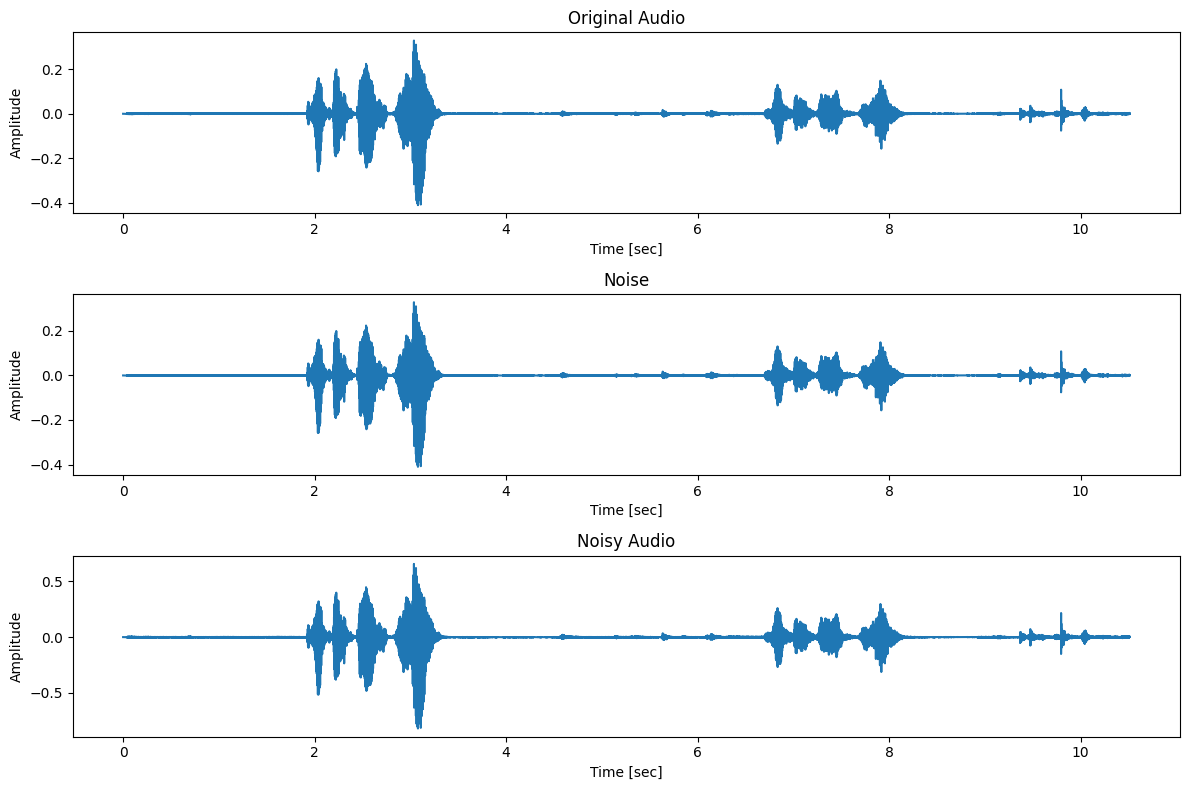

In [49]:
plot_signals(audio, noise, noisy_audio, 16000)

## 3.

In [50]:
def compute_energy(audio, sampling_rate, window_size, hop_size):
    frame_length = int(sampling_rate * window_size)
    hop_length = int(sampling_rate * hop_size)
    energy = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    time = librosa.frames_to_time(np.arange(len(energy)), sr=sampling_rate, hop_length=hop_length)
    return energy, time

def get_threshold(audio, energy, threshold_ratio=0.1):
    threshold = threshold_ratio * np.max(energy)
    return threshold

In [51]:
def plot_energy_and_threshold(audio, energy, time, threshold):
    plt.figure(figsize=(10, 4))
    plt.plot(time, energy, label="Energy")
    plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Time [sec]")
    plt.ylabel("Energy")
    plt.title("Energy Contour with Threshold")
    plt.legend()
    plt.show()

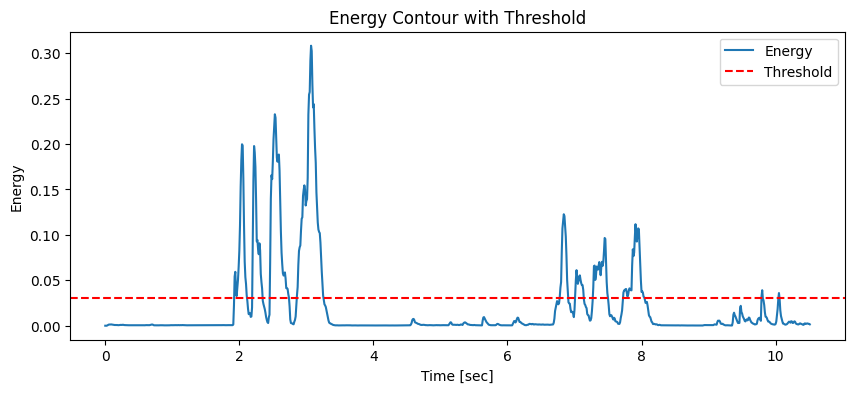

In [52]:
window_size = 0.02  # 20ms
hop_size = 0.01     # 10ms

energy, time = compute_energy(noisy_audio, sampling_rate, window_size, hop_size)

threshold = get_threshold(noisy_audio, energy)

plot_energy_and_threshold(noisy_audio, energy, time, threshold)

In [54]:
def spectral_subtraction(noisy_audio, sampling_rate, threshold, energy, window_size, hop_size):
    frame_length = int(sampling_rate * window_size)
    hop_length = int(sampling_rate * hop_size)

    stft_noisy = librosa.stft(noisy_audio, n_fft=frame_length, hop_length=hop_length)
    magnitude_noisy = np.abs(stft_noisy)
    phase_noisy = np.angle(stft_noisy)

    magnitude_enhanced = np.zeros_like(magnitude_noisy)
    noise_estimation = np.zeros(magnitude_noisy.shape[0])  # Noise spectrum initialized to zeros

    # Iterate over each frame (sequential processing)
    for t in range(magnitude_noisy.shape[1]):
        if energy[t] <= threshold:
            noise_estimation = (noise_estimation + magnitude_noisy[:, t]) / 2  # Running average of noise
        magnitude_enhanced[:, t] = np.maximum(magnitude_noisy[:, t] - noise_estimation, 0)  # Subtract noise and clamp to 0

    stft_enhanced = magnitude_enhanced * np.exp(1j * phase_noisy)
    enhanced_audio = librosa.istft(stft_enhanced, hop_length=hop_length)

    return enhanced_audio


In [55]:
enhanced_audio = spectral_subtraction(noisy_audio, sampling_rate, threshold, energy, window_size, hop_size)

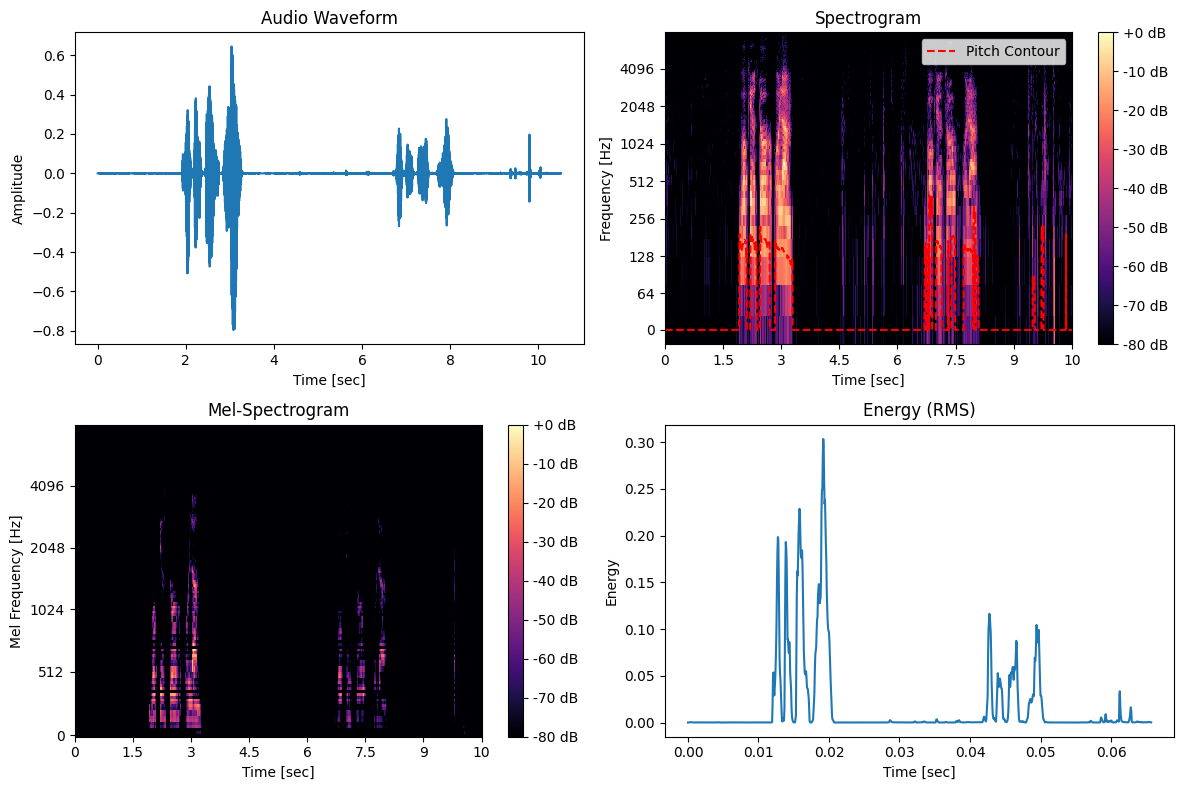

In [56]:
plot_audio_features(enhanced_audio, sampling_rate)

## 4.

Tries:

In [ ]:


# Resample to a new sampling rate using scipy.signal.resample
def resample_audio(audio, original_sr, target_sr):
    num_samples = round(len(audio) * float(target_sr) / original_sr)
    resampled_audio = scipy.signal.resample(audio, num_samples)
    return resampled_audio.astype(np.float32)

# Plot function
def plot_audio_features(audio, sr):
    # Time axis
    time = np.arange(len(audio)) / sr

    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

    # Mel-Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=int(sr * 0.02), hop_length=int(sr * 0.01))
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)

    # Energy (RMS)
    energy = librosa.feature.rms(y=audio)[0]

    # Pitch contour
    f0, time_f0 = pyworld.dio(audio, sr)
    pitch = pyworld.stonemask(audio, f0, time_f0, sr)

    # Plotting
    plt.figure(figsize=(12, 8))

    # Audio waveform
    plt.subplot(2, 2, 1)
    plt.plot(time, audio)
    plt.title('Audio Waveform')
    plt.xlabel('Time [sec]')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(2, 2, 2)
    specshow(D, x_axis='time', y_axis='log', sr=sr)
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    # Pitch contour on spectrogram
    plt.plot(time_f0, pitch, label='Pitch Contour', color='r', linestyle='dashed')
    plt.legend()

    # Mel-Spectrogram
    plt.subplot(2, 2, 3)
    specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
    plt.title('Mel-Spectrogram')
    plt.colorbar(format='%+2.0f dB')

    # Energy (RMS)
    plt.subplot(2, 2, 4)
    plt.plot(time[:len(energy)], energy)
    plt.title('Energy (RMS)')
    plt.xlabel('Time [sec]')
    plt.ylabel('Energy')

    plt.tight_layout()
    plt.show()

# Load and process audio
file_path = "recording.wav"  # Replace with your audio file path# Load the noise audio file and resample it to 16KHz
def load_and_resample(file_path, target_sr):
    noise, sr = librosa.load(file_path, sr=None, mono=True)
    noise_resampled = resample_audio(noise, sr, target_sr)
    return noise_resampled, target_sr

# Add noise to the audio
def add_noise_to_audio(audio, noise):
    # Truncate noise if it is longer than the audio
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    # Truncate audio if it is longer than the noise
    elif len(audio) > len(noise):
        audio = audio[:len(noise)]
    # Add noise to audio
    noisy_audio = audio + noise
    return audio, noise, noisy_audio

# Plot the signals
def plot_signals(audio, noise, noisy_audio, sr):
    time = np.arange(len(audio)) / sr

    plt.figure(figsize=(12, 8))

    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time, audio)
    plt.title("Original Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noise
    plt.subplot(3, 1, 2)
    plt.plot(time, noise)
    plt.title("Noise")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noisy audio
    plt.subplot(3, 1, 3)
    plt.plot(time, noisy_audio)
    plt.title("Noisy Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Load and process the stationary noise
noise_file_path = "stationary_noise.wav"  # Replace with the noise file path
noise, noise_sr = load_and_resample(noise_file_path, 16000)

# Use one of the downsampled audio signals from Q1.c.2 (e.g., audio_downsampled_resample)
audio_downsampled_resample = resample_audio(audio_32kHz, 32000, 16000)

# Add noise to the audio
audio, noise, noisy_audio = add_noise_to_audio(audio_downsampled_resample, noise)

# Plot the results
plot_signals(audio, noise, noisy_audio, 16000)

audio, sr = load_audio(file_path)

# Resample to 32KHz
audio_32kHz = resample_audio(audio, sr, 32000)

# Downsample to 16KHz using two methods:
# Method 1: Taking every even sample
audio_downsampled_even = audio_32kHz[::2]

# Method 2: Resampling using scipy
audio_downsampled_resample = resample_audio(audio_32kHz, 32000, 16000)

# Plotting
plot_audio_features(audio_32kHz, 32000)
plot_audio_features(audio_downsampled_even, 16000)
plot_audio_features(audio_downsampled_resample, 16000)

# Listen to the outputs:
# Use an audio player (e.g., IPython display or save the audio files to listen).


In [ ]:
# Load the noise audio file and resample it to 16KHz
def load_and_resample(file_path, target_sr):
    noise, sr = librosa.load(file_path, sr=None, mono=True)
    noise_resampled = resample_audio(noise, sr, target_sr)
    return noise_resampled, target_sr

# Add noise to the audio
def add_noise_to_audio(audio, noise):
    # Truncate noise if it is longer than the audio
    if len(noise) > len(audio):
        noise = noise[:len(audio)]
    # Truncate audio if it is longer than the noise
    elif len(audio) > len(noise):
        audio = audio[:len(noise)]
    # Add noise to audio
    noisy_audio = audio + noise
    return audio, noise, noisy_audio

# Plot the signals
def plot_signals(audio, noise, noisy_audio, sr):
    time = np.arange(len(audio)) / sr

    plt.figure(figsize=(12, 8))

    # Plot original audio
    plt.subplot(3, 1, 1)
    plt.plot(time, audio)
    plt.title("Original Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noise
    plt.subplot(3, 1, 2)
    plt.plot(time, noise)
    plt.title("Noise")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    # Plot noisy audio
    plt.subplot(3, 1, 3)
    plt.plot(time, noisy_audio)
    plt.title("Noisy Audio")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Load and process the stationary noise
noise_file_path = "stationary_noise.wav"  # Replace with the noise file path
noise, noise_sr = load_and_resample(noise_file_path, 16000)

# Use one of the downsampled audio signals from Q1.c.2 (e.g., audio_downsampled_resample)
audio_downsampled_resample = resample_audio(audio_32kHz, 32000, 16000)

# Add noise to the audio
audio, noise, noisy_audio = add_noise_to_audio(audio_downsampled_resample, noise)

# Plot the results
plot_signals(audio, noise, noisy_audio, 16000)


In [ ]:
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt
from librosa.display import specshow

# Compute short-term energy
def compute_energy(audio, sr, window_size, hop_size):
    frame_length = int(sr * window_size)
    hop_length = int(sr * hop_size)
    energy = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    time = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    return energy, time

# Voice Activity Detection (VAD)
def vad(audio, sr, energy, threshold_ratio=0.1):
    threshold = threshold_ratio * np.max(energy)
    vad_mask = energy > threshold
    return vad_mask, threshold

# Spectral Subtraction
def spectral_subtraction(noisy_audio, sr, vad_mask, window_size, hop_size):
    # Compute STFT
    stft_noisy = librosa.stft(noisy_audio, n_fft=int(sr * window_size), hop_length=int(sr * hop_size))
    magnitude_noisy = np.abs(stft_noisy)
    phase_noisy = np.angle(stft_noisy)

    # Estimate noise spectrum
    noise_frames = magnitude_noisy[:, ~vad_mask]
    noise_estimation = np.mean(noise_frames, axis=1, keepdims=True)

    # Spectral subtraction
    magnitude_enhanced = magnitude_noisy - noise_estimation
    magnitude_enhanced = np.maximum(magnitude_enhanced, 0)  # Avoid negative values

    # Reconstruct enhanced signal
    stft_enhanced = magnitude_enhanced * np.exp(1j * phase_noisy)
    enhanced_audio = librosa.istft(stft_enhanced, hop_length=int(sr * hop_size))
    return enhanced_audio

# Plotting results
def plot_energy_and_vad(audio, sr, energy, time, vad_mask, threshold):
    plt.figure(figsize=(10, 4))
    plt.plot(time, energy, label="Energy")
    plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
    plt.fill_between(time, 0, energy, where=vad_mask, alpha=0.3, label="Speech Regions")
    plt.xlabel("Time [sec]")
    plt.ylabel("Energy")
    plt.title("Energy Contour with VAD Threshold")
    plt.legend()
    plt.show()

# Main workflow
def enhance_audio(noisy_audio, sr):
    # Parameters
    window_size = 0.02  # 20ms
    hop_size = 0.01     # 10ms

    # Compute energy
    energy, time = compute_energy(noisy_audio, sr, window_size, hop_size)

    # VAD
    vad_mask, threshold = vad(noisy_audio, sr, energy)

    # Plot energy contour and VAD regions
    plot_energy_and_vad(noisy_audio, sr, energy, time, vad_mask, threshold)

    # Apply spectral subtraction
    enhanced_audio = spectral_subtraction(noisy_audio, sr, vad_mask, window_size, hop_size)

    return enhanced_audio

# Load noisy audio (from Q2.b)
noisy_audio, sr = noisy_audio, 16000  # Assuming 16KHz sampling rate from Q2.b

# Enhance the noisy audio
enhanced_audio = enhance_audio(noisy_audio, sr)

# Plot the results using the function from Q1.d
plot_audio_features(enhanced_audio, sr)


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Parameters
DESIRED_RMS_DB = -20  # Desired RMS in dB
NOISE_FLOOR_DB = -50  # Noise floor threshold in dB
WINDOW_SIZE = 1.0  # 1 second window for RMS calculation
HOP_SIZE = 0.01    # 10ms hop size
SIGMOID_ALPHA = 10  # Sigmoid parameter for clipping prevention

# Convert dB to linear scale
def db_to_linear(db):
    return 10**(db / 20)

# Compute RMS for sliding window
def compute_rms(audio, sr, window_size, hop_size):
    frame_length = int(sr * window_size)
    hop_length = int(sr * hop_size)
    rms = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]
    time = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
    return rms, time

# Apply AGC
def auto_gain_control(audio, sr, desired_rms_db, noise_floor_db, window_size, hop_size, sigmoid_alpha):
    # Convert to linear scale
    desired_rms = db_to_linear(desired_rms_db)
    noise_floor = db_to_linear(noise_floor_db)

    # Compute RMS
    rms, time = compute_rms(audio, sr, window_size, hop_size)

    # Calculate gain
    gain = np.zeros_like(rms)
    for i in range(len(rms)):
        if rms[i] > noise_floor:
            gain[i] = desired_rms / rms[i]
        else:
            gain[i] = 1.0  # No amplification for noise

    # Smooth gain over time
    gain_smoothed = scipy.signal.medfilt(gain, kernel_size=5)

    # Apply gain to audio
    frame_length = int(sr * window_size)
    hop_length = int(sr * hop_size)
    enhanced_audio = np.zeros_like(audio)
    for i, g in enumerate(gain_smoothed):
        start = i * hop_length
        end = start + frame_length
        enhanced_audio[start:end] += audio[start:end] * g

    # Apply sigmoid to prevent overflow
    enhanced_audio = 1 / (1 + np.exp(-sigmoid_alpha * enhanced_audio))

    return enhanced_audio, gain_smoothed, time

# Plot scaling factors vs. time
def plot_scaling_factors(time, gain):
    plt.figure(figsize=(10, 4))
    plt.plot(time, gain)
    plt.title("Scaling Factors vs Time")
    plt.xlabel("Time [sec]")
    plt.ylabel("Gain Factor")
    plt.grid()
    plt.show()

# Main workflow
def apply_agc(audio, sr):
    # Apply AGC
    enhanced_audio, gain, time = auto_gain_control(
        audio, sr, DESIRED_RMS_DB, NOISE_FLOOR_DB, WINDOW_SIZE, HOP_SIZE, SIGMOID_ALPHA
    )

    # Plot enhanced audio using function from Q1.d
    plot_audio_features(enhanced_audio, sr)

    # Plot scaling factors
    plot_scaling_factors(time, gain)

    return enhanced_audio

# Load audio from Q1.c.2
audio, sr = audio_downsampled_resample, 16000  # Assuming 16KHz sampling rate from Q1.c.2

# Apply AGC
enhanced_audio = apply_agc(audio, sr)


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Parameters
SPEED_FACTOR = 1.5
WINDOW_SIZE = 2048  # Window size for STFT
HOP_SIZE = 512      # Hop size for STFT

# Load the audio
audio, sr = audio_downsampled_resample, 16000  # Assuming 16KHz audio from Q1.c.2

# Time-stretching using phase vocoder
def phase_vocoder_time_stretch(audio, sr, speed_factor, window_size, hop_size):
    # Compute STFT
    stft_matrix = librosa.stft(audio, n_fft=window_size, hop_length=hop_size)
    magnitude, phase = np.abs(stft_matrix), np.angle(stft_matrix)

    # Time-stretching
    n_frames = stft_matrix.shape[1]
    stretched_frames = int(n_frames / speed_factor)
    new_indices = np.linspace(0, n_frames - 1, stretched_frames)
    stretched_magnitude = magnitude[:, new_indices.astype(int)]

    # Recalculate phase using phase propagation
    phase_advances = np.diff(phase, axis=1)
    phase_advances = np.pad(phase_advances, ((0, 0), (1, 0)), mode='constant')
    new_phase = np.cumsum(phase_advances[:, new_indices.astype(int)], axis=1)
    stretched_stft = stretched_magnitude * np.exp(1j * new_phase)

    # Apply iSTFT
    stretched_audio = librosa.istft(stretched_stft, hop_length=hop_size)

    return stretched_audio

# Time-stretch the audio
stretched_audio = phase_vocoder_time_stretch(audio, sr, SPEED_FACTOR, WINDOW_SIZE, HOP_SIZE)

# Plot time-domain signals
def plot_time_domain(original, stretched, sr):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(original, sr=sr)
    plt.title("Original Audio (Time Domain)")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(stretched, sr=sr)
    plt.title("Time-Stretched Audio (Time Domain)")
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")
    plt.grid()

    plt.tight_layout()
    plt.show()

# Plot spectral domain
def plot_spectral_domain(original, stretched, sr):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    librosa.display.specshow(D_original, sr=sr, x_axis='time', y_axis='log')
    plt.title("Original Audio (Spectral Domain)")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(2, 1, 2)
    D_stretched = librosa.amplitude_to_db(np.abs(librosa.stft(stretched)), ref=np.max)
    librosa.display.specshow(D_stretched, sr=sr, x_axis='time', y_axis='log')
    plt.title("Time-Stretched Audio (Spectral Domain)")
    plt.colorbar(format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

# Plot the results
plot_time_domain(audio, stretched_audio, sr)
plot_spectral_domain(audio, stretched_audio, sr)

# Listen to the result
import IPython.display as ipd
print("Original Audio:")
ipd.display(ipd.Audio(audio, rate=sr))
print("Time-Stretched Audio:")
ipd.display(ipd.Audio(stretched_audio, rate=sr))
